# レポート課題 2020年度
手書き文字データセット MNIST を使った分類問題。前処理、モデル、パラメータ調整を行って
高精度な機械学習モデルを作成してください。精度と採用した方法、ならびにこのノートブックをGoogleフォームに提出。詳細はGithub上の README.md を参照。


MNISTの読み込みと準備

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

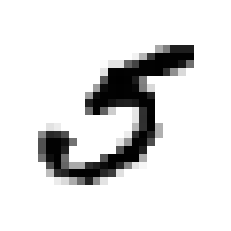

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

plt.show()

In [7]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [8]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

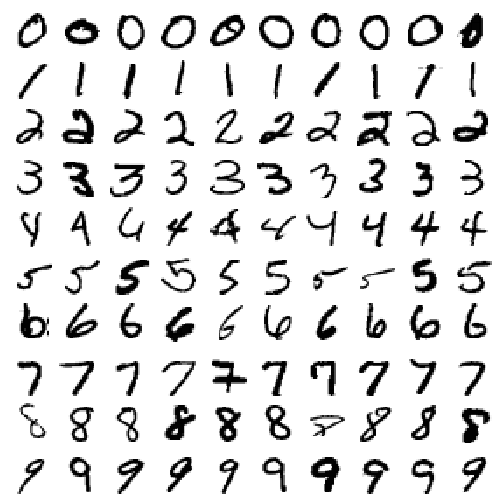

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)

plt.show()

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## KNN 分類器を使った分類
講義で扱った分類器や前処理、グリッドサーチ等を適用してより高い精度を求めてください。

In [11]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

<hr>

# 機械学習2020年度レポート

<div style="text-align: right;">
学籍番号　：20R13118  
</div>
<div style="text-align: right;">
課程：特別聴講学生  
</div>
<div style="text-align: right;">
氏名　：長谷川優太  
</div>


## 目的
このレポートでは、授業の際に習ったプログラミングを中心に実際に自分の手で実装することを目的にする。
具体的には、MNISTの手書数字のデータセットを使用して、分類を行っていくというものである。
授業の際の演習を参考にして、自分でどのような手法を使うとどのようになるかというのを体感したいと思う。

## 方法

様々な手法の中でどのような手法を選択するのが良いのか、という検討が素人の自分にはわからなかった。そこで、Scikit-learnの手法選択のcheat sheetを使ってどの手法を使うのが良いのかという検討を立ててみた。

[参考サイト](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
![](https://scikit-learn.org/stable/_static/ml_map.png)

<hr>

このチートシートにしたがってどのような手法を選ぶのが良いのかというのを考えてみる。  
すると、
1. 50以上のデータがあるか → YES
2. カテゴリー予測か → YES
3. ラベルデータか → YES
4. 100000以上のデータがあるか → NO

という形で**Liner SVC**にたどり着いた。  
この"Linear SVC"というモデルは、授業で扱った"SVC"モデルで線形カーネルのlinearを使うものとは少しばかり違うもののようである。  

[参考サイト](https://scikit-learn.org/stable/modules/svm.html#classification] )




### 【LinearSVC() 】と【SVC(kernel='lsinear')】の違い

`LinearSVC()`では線形モデルとして分類していくため、`SVC(kernel='lsinear)`のようにカーネルを指定することはできない。また、`LinearSVC()`ではカーネルトリックを使用することはできない。  
`LinearSVC`の方ではヒンジ損失関数の２乗を最小化するのに対して、通常の`SVC`では通常のヒンジ損失関数を最小化することになっているようだ。
ヒンジ損失関数は、サポートベクターマシーンなどに用いられる損失関数で、誤分類に対してペナルティを課すというものである。
このヒンジ関数を二乗にするかどうかはハイパーパラメータによって調整が可能なようだ。

#### クラス分類の手法の違い
`LinearSVC()`では、一対他分類器を使用しているのに対して、`SVC()`では、一対一分類器と一対他分類器の指定をすることが可能である。 それぞれの違いは、AI研究所のページによると以下のようになっている。  

[引用サイト](https://ai-kenkyujo.com/term/classification/)

>1対多分類器（one-vs.-rest classifier）
クラスごとに判別式を用意し、対象データにすべての式を適用します、そして次に、最も高い確率のクラスに割り当てるというクラス分類の方法。

>1対1分類器（one-vs.-one classifier）
全個のクラスから2個を判別する式を、クラス選択分用意する。
その後、データをすべて判別式に適用し、結果の多数決でクラスを決定するクラス分類の方法。

具体的な話をすると、分類器の数に違いが出てくるようだ。今回のように10つのクラスに分けるの場合を考えてみる。One-VS-Restの場合には、10この2値分類器を学習するのに対して、One-VS-Oneの場合には、45この2値分類器を学習することになる。そのため、One-VS-Restの方が高速に学習を完了させることが可能である。ただ、各分類器に用いるデータのクラスの割合が偏ってしまう可能性があることがOne-VS-Restの短所だ。一方で、One-VS-Oneの場合には学習には時間がかかるものの、各学習に用いるデータの偏りは小さくて済むことになる。
以下にそれぞれのクラス分類の方法について表でまとめてみた。


|  手法| クラスの数|分類器の数|長所|短所|
| :----: | :--:  |:--:|:--:|:--:|
|  One-VS-Rest |n|n|学習が少ない|偏ることがある|
|  One-VS-One  |n|n (n - 1) / 2|偏りが小さい|学習が多い|

これらのことから、非確定簡単にサポートベクターマシーンを使用する際には、`LinearSVC()`、非線形な分類や、One-VS-Restなどを使用する際には、`SVC()`を使用するのが妥当ではないかと考えられる。  

[参考サイト](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html)  
[参考サイト2](https://scikit-learn.org/stable/modules/svm.html#classification)  

では実際に、MNISTの分類問題について取り組んでいこおうと思う。ひとまず、Scikit-learnのチートシートにしたがって、`LinearSVC()`を使用してモデルの作成をしていこうと思う。


## 実行結果
### LinearSVC

In [17]:
# モデルの作成・学習
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train, y_train)

# 予測
y_svm_pred = svm.predict(X_test)

# スコア
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_svm_pred)

/Users/hasegawayuta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.8727

### 特徴量スケーリング

そのままの訓練データに対してLinearSVCのモデルで学習を行うと、スコアは**0.8727**になった。このスコアでは少し低すぎるため、訓練データの特徴量をスケーリングしたいと思う。授業で習った最小値と最大値を0~1にする正規化を試してみる。

In [18]:
# min-maxスケーリングによる[0,1]の範囲へスケーリング

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

In [19]:
# 学習
svm.fit(X_train_norm, y_train)

# 予測
y_svm_pred = svm.predict(X_test_norm)

# スコア
accuracy_score(y_test, y_svm_pred)

/Users/hasegawayuta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.918

先ほどと同じLinearSVCのモデルを使用したが、特徴量スケーリングによってスコアが上昇したのが確認できた。次に、平均を0，分散を1とする標準化を試してみる。

In [20]:
# 標準化
    
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

In [21]:
# 学習
svm.fit(X_train_std, y_train)

# 予測
y_svm_pred = svm.predict(X_test_std)

# スコア
accuracy_score(y_test, y_svm_pred)

/Users/hasegawayuta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9086

`/Users/hasegawayuta/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)`  
というエラーが出ているため、`max_iter=10000`に設定してもう一度モデルを作成した。  
しかし、スコアに変化はなかった↓

In [52]:
# モデルの作成・学習
svm = LinearSVC(max_iter=10000)
svm.fit(X_train_norm, y_train)

# 予測
y_svm_pred = svm.predict(X_test_norm)

# スコア
accuracy_score(y_test, y_svm_pred)

0.918

標準化した場合には、スコアが0.9086に改善したことが確認された。
スケーリングをしていない場合、正規化した場合、標準化した場合のそれぞれの結果をまとめると以下のようになる。

|なし|正規化|標準化|
|:-:|:-:|:-:|
|0.8727|0.918|0.9086|

これらの結果から特徴量スケーリングによって実際にスコアが改善することが確認できた。

<hr>

先ほどのチートシートに従って、より良いモデルを探してみようと思う。

![](https://scikit-learn.org/stable/_static/ml_map.png)

このチートシートでは、LinearSVMがうまくいかなそうな場合には、k近傍法を使うと良いとされている。そこで、続いてはk近傍法をモデルにして学習をしてこうと思う。まずは、何も処理をしていない訓練データに、このipynbファイルをダウンロードしたといに設定されていたハイパーパラメータを指定して学習していこうと思う。

### k近傍法

In [25]:
# モデルの作成・学習
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=1)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9691

それでは、先ほどと同じように特徴量スケーリングをしてみたいと思う。  
上から順に正規化をした訓練データ、標準化した訓練データを学習させたものである。

In [28]:
# 学習
knn_clf.fit(X_train_norm, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test_norm)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9691

In [27]:
# 学習
knn_clf.fit(X_train_std, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test_std)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9434

これら3つの結果から、

|なし|正規化|標準化|
|:-:|:-:|:-:|
|0.9691|0.9691|0.9434|

というスコアになった。このことから特徴量スケーリングが必ずしもスコアを改善させるとは限らないということがわかった。  
原因について考えてみたが、自分では結論を出すことができなかった。  

次に、授業で習った適切なハイパーパラメータを探すグリッドサーチをやっていきたいと思う。授業ではfor文を回してパイプラインを使用してやっていたが、学習時間が予想以上にかかることから、一つ一つセルで実行していくっことにする。
ハイパーパラメータの探索対象は、`n_neighbors`（近傍オブジェクト数）でいくつの点を探すかというものである。

### グリッドサーチ、クロスバリデーション

In [31]:
# モデルの作成・学習(n_neighbors=2)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=2)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9691

In [32]:
# モデルの作成・学習(n_neighbors=3)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=3)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9717

In [33]:
# モデルの作成・学習(n_neighbors=4)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test) 

# スコア
accuracy_score(y_test, y_knn_pred)

0.9714

In [34]:
# モデルの作成・学習(n_neighbors=5)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=5)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9691

In [39]:
# モデルの作成・学習(n_neighbors=6)
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=6)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9709

In [42]:
# モデルの作成・学習
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=7)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.97

In [44]:
# モデルの作成・学習
knn_clf = KNeighborsClassifier(n_jobs=-1, weights='distance', n_neighbors=20)
knn_clf.fit(X_train, y_train)

# 予測
y_knn_pred = knn_clf.predict(X_test)

# スコア
accuracy_score(y_test, y_knn_pred)

0.9633

これらの計算からハイパーパラメータとスコアの関係は以下のようになった。  

|n_neighbors|1|2|3|4|5|6|7|20|
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|score|0.9691|0.9691|0.9717|0.9714|0.9691|0.9709|0.97|0.9633|

グリッドサーチを行う前には、n_neighborsの数値を上げるほどスコアも上昇すると考えていたが、実際にはそんなことはなく、0.97付近で少々動くだけにとどまった。おそらく、グリッドサーチで探索している幅が1刻みであったために大きな差異が生まれなかったものだと考えられる。 

<hr>

最後の説明可能なAIということがどういったことなのかを知りたかったため、決定木の可視化について調べてみた。  
どうやら、scikit-learnの`sklearn.tree.export_graphviz`というのを使うことによって、決定技の分岐を可視化したものを出力できるようである。  
[参考サイト](https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html?highlight=export_graphviz)  

また、scikit-learnの0.21.以降からは`sklearn.tree.plot_tree`でより簡単に分岐の表示がで切るようになったらしい  
[参考サイト](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html?highlight=plot%20tree#sklearn.tree.plot_tree)  

下に、実際に決定木の分岐を表示した。

### 決定木

In [53]:
# モデルの作成
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth = 3)
dt.fit(X_train, y_train)

# 予測
y_tree_pred = dt.predict(X_test)

# スコア
accuracy_score(y_test, y_tree_pred)

0.4953

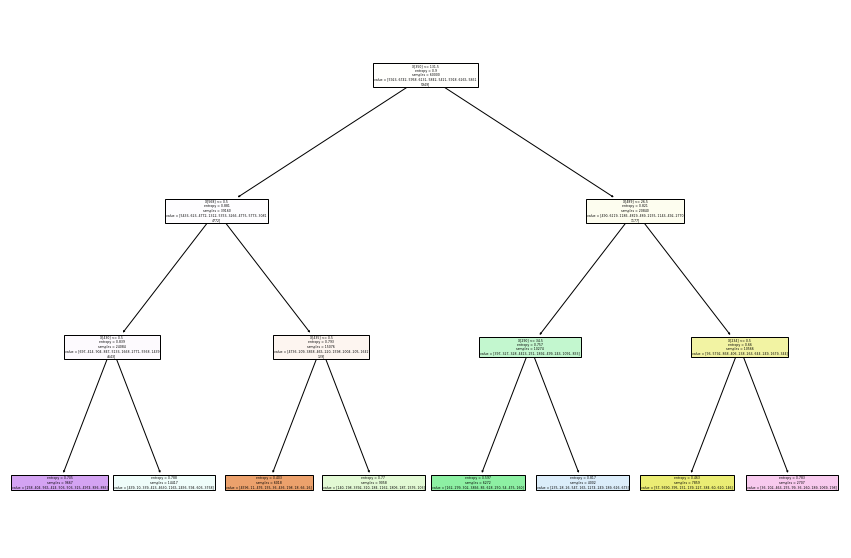

In [54]:
import matplotlib.pyplot as plt

# 決定木の視覚化
plt.figure(figsize=(15, 10))
tree.plot_tree(dt, filled=True)
plt.show()

## まとめ

今回のレポートでは、MNISTのデータセットをscikit-learnの手法選択のチートシートにそってモデルを作っていった。初めは、サポートベクターマシーンの線形モデルによる分類を試みた。  
その中で、特徴量スケーリングによってスコアがどのように変化するかについても見てきた。次に、チートシートに従ってknnのモデルを作ってみた。こちらでも特徴量スケーリングによるスコアの変化についてみた。SVMの方では特徴量スケーリングによってスコアの改善がみられたが、knnの方では特徴量スケーリングによってスコアの低下が見られた。スコアが低下した原因はわからないが、特徴量スケーリングが効果的なモデルとそうでないモデルがあるということを理解することができた。特にサポートベクターマシーンでは特徴量スケーリングが有効的であるということがわかった。  
グリッドサーチについては、ハイパーパラメータの数が大きくなればなるほどスコアも改善するというわけではないということがわかった。  

今回のモデルの中で最も高いスコアを出したのは、k近傍法モデルのn_neighbors=3の時で、scoreは0.9717であった。このことから、scikit-learnの手法選択のチートシートに従ってやれば、それなりの精度を実現することができるということがわかった。しかしながら、自分の手でデータの前処理や手法の選択、ハイパーパラメータの調整などをする必要があるということを改めて実感し、ノーフリーランチという言葉の重さを感じた。  
また、想像以上に一つのモデルの学習に時間がかかり、非常に大変な作業であるということも感じた。  

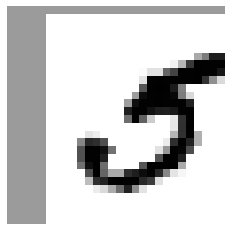

In [55]:
#テスト結果の描画。おまけ。
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))